# Compute score sentiment on FED speeches from 1996-12-19 to 2023-01-06

In [5]:
!pip install transformers
!pip install torch torchvision

In [6]:
import pandas as pd
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

## Import Data

In [7]:
df_fed_speeches  = pd.read_csv("fed_speeches_1996_2020-4.csv")

In [8]:
df_fed_speeches

,link,title,speaker,event,year,text,date,text_len
0,https://www.federalreserve.gov/boarddocs/speec...,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996.0,I discovered when I joined the Board of Govern...,19961219.0,3671
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996.0,I am privileged to accept the Union League of...,19961206.0,2596
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996.0,The Challenge of Central Banking in a Democrat...,19961205.0,4344
3,https://www.federalreserve.gov/boarddocs/speec...,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996.0,It is a pleasure to be with you this morning ...,19961203.0,2527
4,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996.0,Supervisory and Regulatory Responses to Financ...,19961125.0,2222
...,...,...,...,...,...,...,...,...
2540,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Governor Christopher J. Waller,At the C. Peter McColough Series on Internatio...,2023.0,"January 20, 2023 A Case for Cautious Optimism...",20230120.0,2025
2541,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Vice Chair Lael Brainard,At the University of Chicago Booth School of B...,2023.0,"January 19, 2023 Staying the Course to Bring ...",20230119.0,3063
2542,https://www.federalreserve.gov/newsevents/spee...,Governor Michelle W. Bowman,At the Florida Bankers Association Leadership ...,Governor Bowman presented identical remarks to...,2023.0,"January 10, 2023 Brief Remarks on the Economy...",20230110.0,1913
2543,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Chairman Jerome H. Powell,"At the Symposium on Central Bank Independence,...",2023.0,"January 10, 2023 Panel on ""Central Bank Indep...",20230110.0,1269


### Data cleansing

In [9]:
# Convert the date to a string and then to a datetime object
df_fed_speeches['date'] = pd.to_datetime(df_fed_speeches['date'], format='%Y%m%d')
df_fed_speeches

,link,title,speaker,event,year,text,date,text_len
0,https://www.federalreserve.gov/boarddocs/speec...,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996.0,I discovered when I joined the Board of Govern...,1996-12-19,3671
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996.0,I am privileged to accept the Union League of...,1996-12-06,2596
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996.0,The Challenge of Central Banking in a Democrat...,1996-12-05,4344
3,https://www.federalreserve.gov/boarddocs/speec...,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996.0,It is a pleasure to be with you this morning ...,1996-12-03,2527
4,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996.0,Supervisory and Regulatory Responses to Financ...,1996-11-25,2222
...,...,...,...,...,...,...,...,...
2540,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Governor Christopher J. Waller,At the C. Peter McColough Series on Internatio...,2023.0,"January 20, 2023 A Case for Cautious Optimism...",2023-01-20,2025
2541,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Vice Chair Lael Brainard,At the University of Chicago Booth School of B...,2023.0,"January 19, 2023 Staying the Course to Bring ...",2023-01-19,3063
2542,https://www.federalreserve.gov/newsevents/spee...,Governor Michelle W. Bowman,At the Florida Bankers Association Leadership ...,Governor Bowman presented identical remarks to...,2023.0,"January 10, 2023 Brief Remarks on the Economy...",2023-01-10,1913
2543,https://www.federalreserve.gov/newsevents/spee...,Watch Live,Chairman Jerome H. Powell,"At the Symposium on Central Bank Independence,...",2023.0,"January 10, 2023 Panel on ""Central Bank Indep...",2023-01-10,1269


### Import the model

In [10]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

### Compute the sentiement score

To compute the sentiment score of a sentence, the model will provide three probability scores :
* negative score
* neutral score
* positive score

In [11]:
%%time

def compute_sentiment_score(text, display=False):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model
    with torch.no_grad():  # Ensure no gradient is computed
        outputs = model(**inputs)

    # Get the logits from the output
    logits = outputs.logits

    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1).squeeze().tolist()

    # Extract negative, neutral, and positive scores based on the model's output structure
    negative_score, neutral_score, positive_score = probabilities

    bert_sentiment_output = {
        "positive_score": positive_score,
        "neutral_score": neutral_score,
        "negative_score": negative_score
    }

    # Create a DataFrame
    data = {
        "ecb_statement": [text],
        "negative_score": [negative_score],
        "neutral_score": [neutral_score],
        "positive_score": [positive_score],
        "sentiment_score": [bert_sentiment_output]
    }

    df_sentiment = pd.DataFrame(data)

    if display == True:
      # Print the sentiment scores
      print("##########################################")
      print("Sentiment Scores of the ECB Statement:")
      print("##########################################")
      print(f"Negative Score: {negative_score}")
      print(f"Neutral Score: {neutral_score}")
      print(f"Positive Score: {positive_score}")

    return df_sentiment

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


In [12]:
# Init dataframe

text1 = df_fed_speeches['text'][0]
df_fed_sentiment_score = compute_sentiment_score(text1, False)

for i in range (1, len(df_fed_speeches)-1):
    print("text number ", i)
    df_temp = compute_sentiment_score(df_fed_speeches['text'][i], False)
    df_fed_sentiment_score = pd.concat([df_fed_sentiment_score, df_temp], ignore_index=True, sort=False)

text number  1
text number  2
text number  3
text number  4
text number  5
text number  6
text number  7
text number  8
text number  9
text number  10
text number  11
text number  12
text number  13
text number  14
text number  15
text number  16
text number  17
text number  18
text number  19
text number  20
text number  21
text number  22
text number  23
text number  24
text number  25
text number  26
text number  27
text number  28
text number  29
text number  30
text number  31
text number  32
text number  33
text number  34
text number  35
text number  36
text number  37
text number  38
text number  39
text number  40
text number  41
text number  42
text number  43
text number  44
text number  45
text number  46
text number  47
text number  48
text number  49
text number  50
text number  51
text number  52
text number  53
text number  54
text number  55
text number  56
text number  57
text number  58
text number  59
text number  60
text number  61
text number  62
text number  63
t

In [13]:
df_fed_sentiment_score

,ecb_statement,negative_score,neutral_score,positive_score,sentiment_score
0,I discovered when I joined the Board of Govern...,0.000157,0.999308,0.000535,"{'positive_score': 0.000535328290425241, 'neut..."
1,I am privileged to accept the Union League of...,0.919487,0.010081,0.070432,"{'positive_score': 0.07043204456567764, 'neutr..."
2,The Challenge of Central Banking in a Democrat...,0.000233,0.992198,0.007568,"{'positive_score': 0.007568394765257835, 'neut..."
3,It is a pleasure to be with you this morning ...,0.000192,0.002066,0.997742,"{'positive_score': 0.99774169921875, 'neutral_..."
4,Supervisory and Regulatory Responses to Financ...,0.000375,0.069989,0.929637,"{'positive_score': 0.929636538028717, 'neutral..."
...,...,...,...,...,...
2539,"January 21, 2023 Remarks to Delta Sigma Theta...",0.000064,0.999716,0.000220,"{'positive_score': 0.00022000882017891854, 'ne..."
2540,"January 20, 2023 A Case for Cautious Optimism...",0.987604,0.001798,0.010597,"{'positive_score': 0.01059745717793703, 'neutr..."
2541,"January 19, 2023 Staying the Course to Bring ...",0.996201,0.000436,0.003363,"{'positive_score': 0.003362625604495406, 'neut..."
2542,"January 10, 2023 Brief Remarks on the Economy...",0.003857,0.983688,0.012455,"{'positive_score': 0.012454804964363575, 'neut..."


### Add DATE column

In [14]:
df_fed_sentiment_score = pd.merge(df_fed_sentiment_score, df_fed_speeches[['date']], left_index=True, right_index=True)
df_fed_sentiment_score

,ecb_statement,negative_score,neutral_score,positive_score,sentiment_score,date
0,I discovered when I joined the Board of Govern...,0.000157,0.999308,0.000535,"{'positive_score': 0.000535328290425241, 'neut...",1996-12-19
1,I am privileged to accept the Union League of...,0.919487,0.010081,0.070432,"{'positive_score': 0.07043204456567764, 'neutr...",1996-12-06
2,The Challenge of Central Banking in a Democrat...,0.000233,0.992198,0.007568,"{'positive_score': 0.007568394765257835, 'neut...",1996-12-05
3,It is a pleasure to be with you this morning ...,0.000192,0.002066,0.997742,"{'positive_score': 0.99774169921875, 'neutral_...",1996-12-03
4,Supervisory and Regulatory Responses to Financ...,0.000375,0.069989,0.929637,"{'positive_score': 0.929636538028717, 'neutral...",1996-11-25
...,...,...,...,...,...,...
2539,"January 21, 2023 Remarks to Delta Sigma Theta...",0.000064,0.999716,0.000220,"{'positive_score': 0.00022000882017891854, 'ne...",2023-01-21
2540,"January 20, 2023 A Case for Cautious Optimism...",0.987604,0.001798,0.010597,"{'positive_score': 0.01059745717793703, 'neutr...",2023-01-20
2541,"January 19, 2023 Staying the Course to Bring ...",0.996201,0.000436,0.003363,"{'positive_score': 0.003362625604495406, 'neut...",2023-01-19
2542,"January 10, 2023 Brief Remarks on the Economy...",0.003857,0.983688,0.012455,"{'positive_score': 0.012454804964363575, 'neut...",2023-01-10


In [15]:
df_fed_sentiment_score.to_csv('sentiment_score_bert_fed.csv', index=False)

### Plot the evolution of sentiment score over time

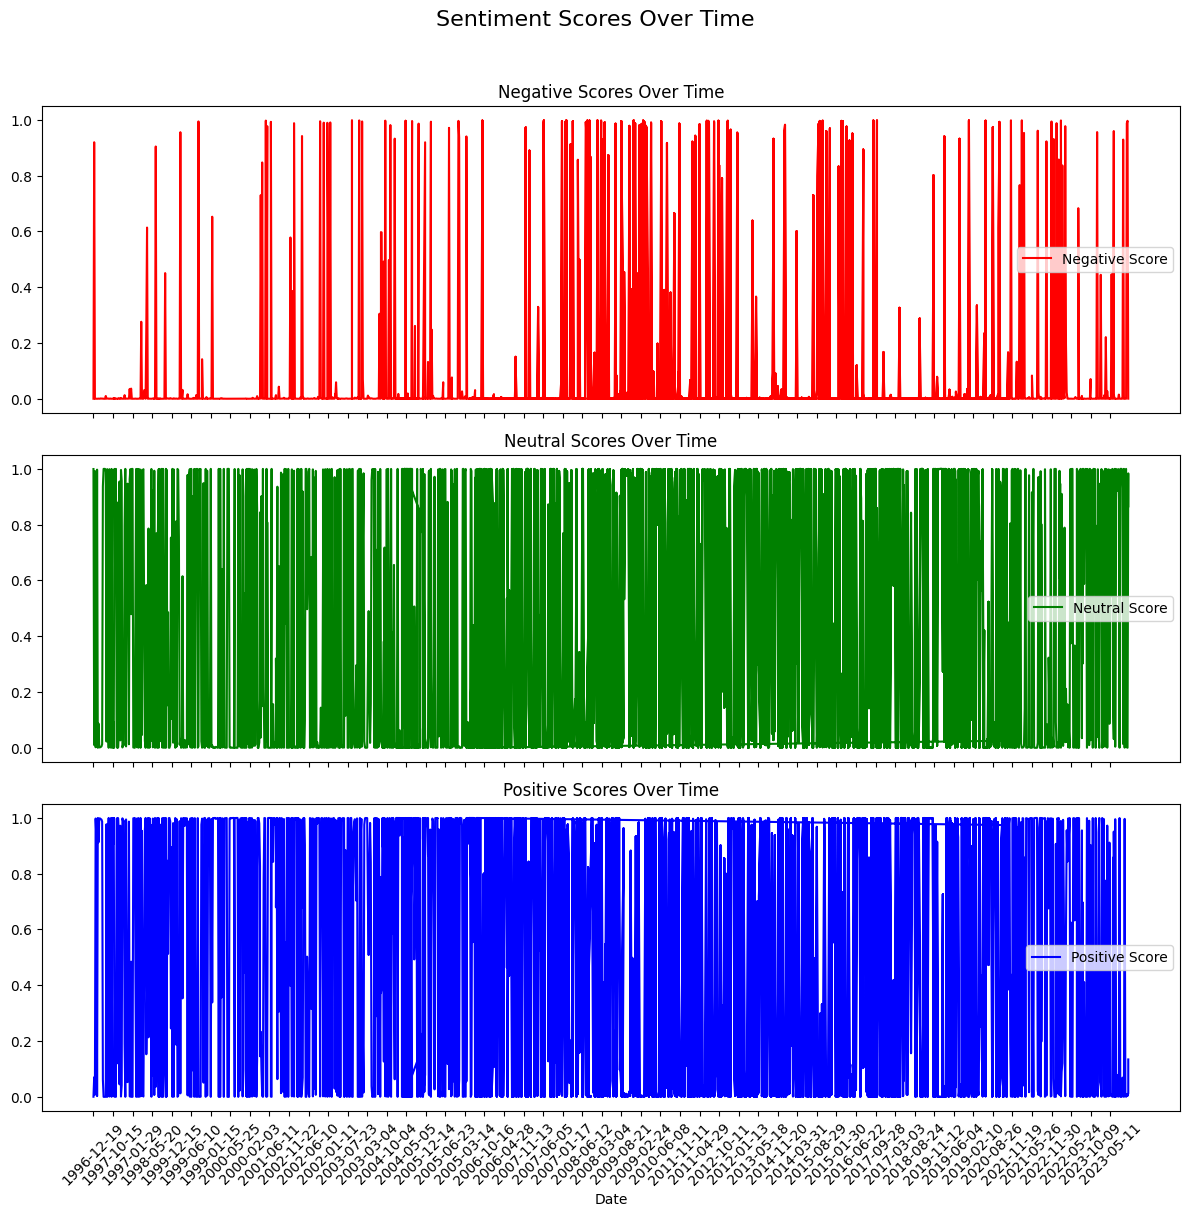

In [16]:
import matplotlib.pyplot as plt

# Convert the Timestamp objects to strings for plotting
date_str = df_fed_sentiment_score['date'].dt.date.astype(str).tolist()

# Transform columns into lists
negative_scores = df_fed_sentiment_score['negative_score'].tolist()
neutral_scores = df_fed_sentiment_score['neutral_score'].tolist()
positive_scores = df_fed_sentiment_score['positive_score'].tolist()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Plot negative scores
axs[0].plot(date_str, negative_scores, label='Negative Score', color='r')
axs[0].set_title('Negative Scores Over Time')
axs[0].legend()

# Plot neutral scores
axs[1].plot(date_str, neutral_scores, label='Neutral Score', color='g')
axs[1].set_title('Neutral Scores Over Time')
axs[1].legend()

# Plot positive scores
axs[2].plot(date_str, positive_scores, label='Positive Score', color='b')
axs[2].set_title('Positive Scores Over Time')
axs[2].legend()

# Set common labels
fig.suptitle('Sentiment Scores Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Adjust layout to accommodate suptitle

# Rotate x-axis labels by 45 degrees and display every third date
for ax in axs:
    ax.set_xticks(ax.get_xticks()[::3])  # Display every third tick
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Date')

# Display the plot
plt.show()

<ipython-input-17-f3341e428a81>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_scores = df_fed_sentiment_score.groupby('month_year').mean()


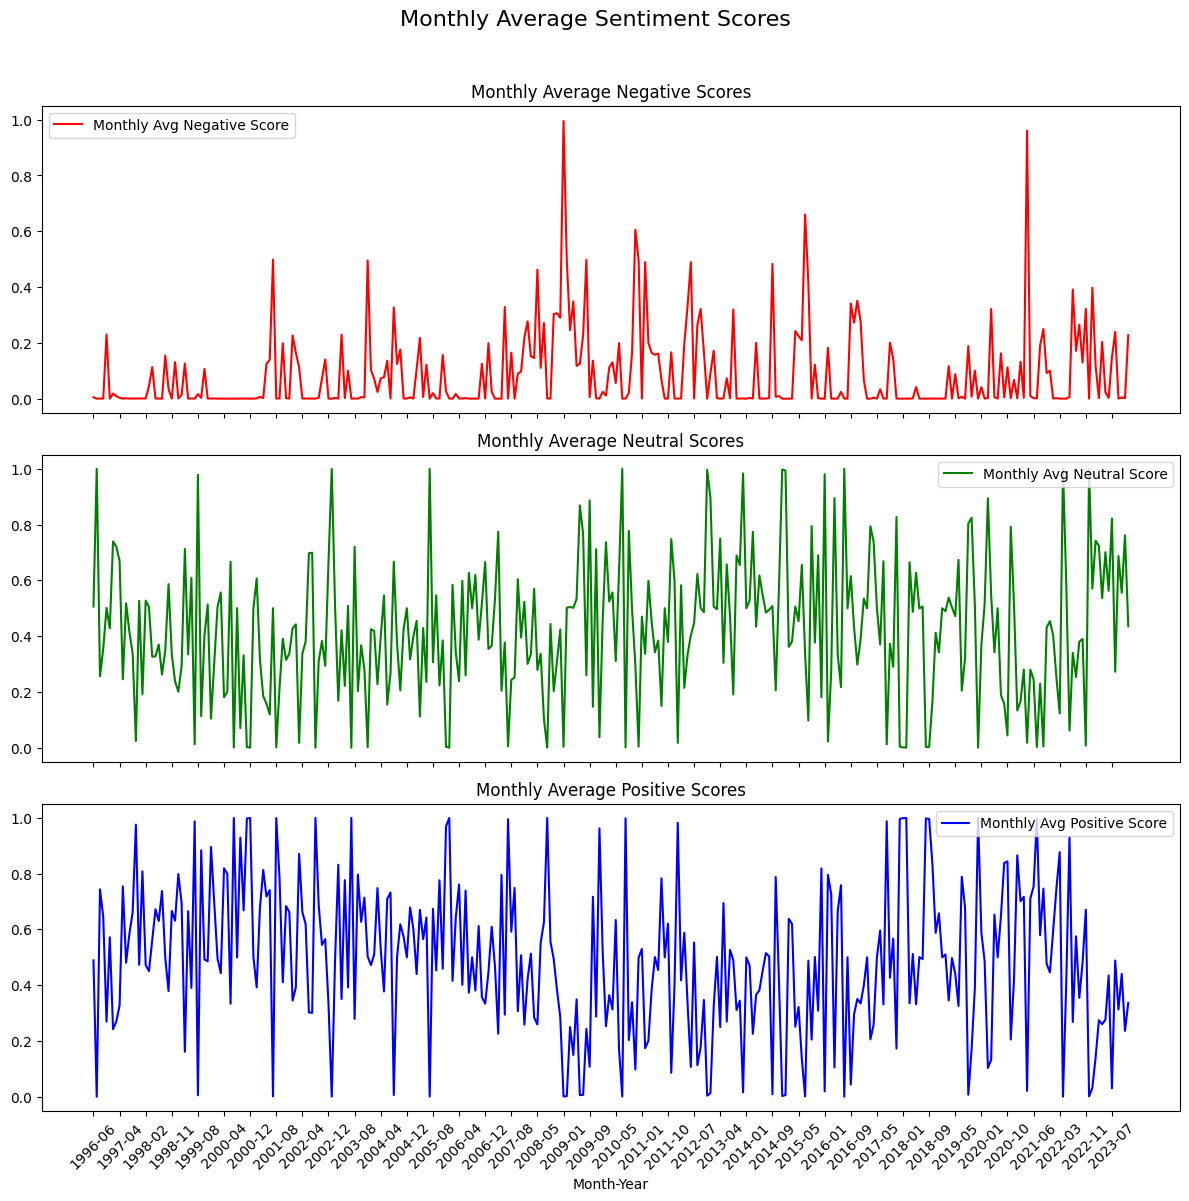

In [17]:
import matplotlib.pyplot as plt

# Convert the Timestamp objects to month-year format for grouping
df_fed_sentiment_score['month_year'] = df_fed_sentiment_score['date'].dt.to_period('M')

# Group by month-year and compute the mean for each group
monthly_avg_scores = df_fed_sentiment_score.groupby('month_year').mean()

# Extract month-year as strings for plotting
months = monthly_avg_scores.index.astype(str).tolist()

# Extract monthly average scores
monthly_negative_scores = monthly_avg_scores['negative_score'].tolist()
monthly_neutral_scores = monthly_avg_scores['neutral_score'].tolist()
monthly_positive_scores = monthly_avg_scores['positive_score'].tolist()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Plot monthly average negative scores
axs[0].plot(months, monthly_negative_scores, label='Monthly Avg Negative Score', color='r')
axs[0].set_title('Monthly Average Negative Scores')
axs[0].legend()

# Plot monthly average neutral scores
axs[1].plot(months, monthly_neutral_scores, label='Monthly Avg Neutral Score', color='g')
axs[1].set_title('Monthly Average Neutral Scores')
axs[1].legend()

# Plot monthly average positive scores
axs[2].plot(months, monthly_positive_scores, label='Monthly Avg Positive Score', color='b')
axs[2].set_title('Monthly Average Positive Scores')
axs[2].legend()

# Set common labels
fig.suptitle('Monthly Average Sentiment Scores', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Adjust layout to accommodate suptitle

# Rotate x-axis labels by 45 degrees and display every third date
for ax in axs:
    ax.set_xticks(ax.get_xticks()[::2])  # Display every third tick
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Month-Year')

# Display the plot
plt.show()
